In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
import nltk
import warnings
import string
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [45]:
def prepare_url(df):
    """
    -Принимает на вход pd.DataFrame.
    -Возвращает pd.Series содержащее названия сайтов url
    
    P.S Добавляет информацию в исходный dataset от названия сайтов их ulr,
    так как после предобработки данных имеются пустые title и соответсовенно сделать предсказание сложно,
    ну и вообще стоит использовать все данные. 
    """
    series_url = df['url'].str.split('.').str[:-1]
    new_dict = {}
    for ind, value in series_url.to_dict().items():
        if len(value) > 1:
            if('www' in value[0]):
                new_dict.update({ind: value[1: ]})
            else:
                new_dict.update({ind: value})
            
        else:
            new_dict.update({ind: value})
    series_url = pd.Series(new_dict)
    series_url = series_url.apply(lambda r: r if len(r) > 0 else [])
    return series_url

def prepare_text_data_new(filename, text_column, list_prepare_func, series_add):
    """
    Принимает на вход название файла с данными (filename) train.csv/test.csv, название колонки(text_column), которую нужно предобработать (title)
    list функций(list_prepare_func), которые убирают всё лишнее из title и организуют список валидный слов, содержащиеся в названии сайта,
    series_add - добавляет в наш title слова из url каждого сайта.
    P.S series_add получается с помощью prepare_url.
    """
    df = pd.read_csv(filename)
    df['title_url'] = series_add
    df['title'] = df.apply(lambda r: r['title'] +  " " + " ".join(r['title_url']), axis = 1)
    assert(df[text_column].dtypes == np.object)
    for func in list_prepare_func:
        df[text_column] = df[text_column].apply(func)
    
    return df

def best_treshold(y_pred_prob, y_true):
    """
    По y_pred_prob - вероятности предсказаний модели, y_true - ответы модели.
    Ищет наилучший порог с точки зрения f1 - меры для получения ответов модели, по которой построен y_pred_prob.
    
    Возвращает лучший f1_score и лучший порог для валидационной выборки.
    """
    thresholds = np.linspace(0., 1., 100)
    the_best_thres = thresholds[0]
    max_score = f1_score(y_true, (y_pred_prob[:, 1] > thresholds[0]).astype(np.int8))
    for thres in thresholds[1:]:
        ans = (y_pred_prob[:, 1] > thres).astype(np.int8)
        if(f1_score(y_true, ans) > max_score):
            the_best_thres = thres
            max_score = f1_score(y_true, ans)
    return max_score, the_best_thres

def cv_emb(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

def plot_score(optimizer):
    """
    по переданному оптимизатору optimizer
    Строит кривую f1_score в зависимости от списка параметров C - как гиперпараметр модели LogisticRegression
    """
    split_score = []
    for key, item in zip(optimizer.cv_results_.keys(), optimizer.cv_results_.values()):
        if "split" in key:
            split_score.append(item)
    split_score = np.array(split_score, dtype = np.float32)
    mean, std = split_score.mean(axis = 0), split_score.std(axis = 0)
    C_array = optimizer.get_params()['param_grid']["C"]
    plt.semilogx(C_array, mean)
    plt.fill_between(C_array, mean - std, mean + std, alpha = 0.3)
    plt.plot(optimizer.best_params_['C'] * np.ones((100, )), np.linspace(mean.min() - std.max(), mean.max() + std.max(), 100), color = 'black')
    plt.show();

In [46]:
import string
table = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('russian')) 

clean_punctuation = lambda raw: [w.translate(table) for w in raw] # убирает пунктуацию
clean_not_alpha = lambda raw: [word for word in raw if word.isalpha()] # только alphabetic слова
clean_one_symb = lambda raw: [word for word in raw if word.__len__() != 1] # убрать односимвольные конструкции 
clean_stop_words = lambda raw: [w for w in raw if w not in stop_words] # Убрать стоп слова (правда я тут убрал только русские)
lower_case = lambda raw: [w.lower() for w in raw] # привести к нижнему регистру

steammed_words = lambda raw: [SnowballStemmer('russian').stem(w) for w in raw] # на всякий слусай произвести стимминг слов  

list_func = [word_tokenize, lower_case, clean_punctuation, clean_not_alpha, clean_stop_words, clean_one_symb]


train_df = pd.read_csv('train.csv')
train_df_prepare = prepare_text_data_new('train.csv', 'title', list_func, prepare_url(train_df))

In [47]:
train_df_prepare.title.values[:10] # Примеры как выглядят списки слов из наших title

array([list(['эксминистр', 'экономики', 'молдовы', 'главе', 'мидэи', 'цель', 'которого', 'сделать', 'республики', 'просителя', 'донора', 'избегать', 'долгого', 'нахождения', 'kp']),
       list(['эта', 'песня', 'стала', 'известна', 'многим', 'телезрителям', 'благодаря', 'сериалу', 'kp']),
       list(['банши', 'сезон', 'серия', 'бремя', 'красоты', 'смотреть', 'онлайн', 'fanserials']),
       list(['беси', 'картинки', 'colorbox', 'spb']),
       list(['новомосковске', 'сыграют', 'следжхоккеисты', 'алексинской', 'звезды', 'сборной', 'китая', 'tulasport']),
       list(['салат', 'корейская', 'морковь', 'копченая', 'курица', 'кукуруза', 'сухарики', 'калорийность', 'белки', 'жиры', 'углеводы', 'beregifiguru']),
       list(['угловой', 'пневмогайковерт', 'fubag', 'rwc', 'екатеринбурге', 'купить', 'цены', 'отзывы', 'характеристики', 'фото', 'инструкция', 'ekb', 'vseinstrumenti']),
       list(['табачный', 'магазин', 'мир', 'табака', 'курительные', 'трубки', 'stanwell', 'курительная', 'труб', 

In [48]:
prepare_url(train_df)[:10] # Списки слов полученных из url объектов 

0                  [m, kp]
1                     [kp]
2             [fanserials]
3          [colorbox, spb]
4             [tula-sport]
5           [beregifiguru]
6    [ekb, vseinstrumenti]
7              [mirtabaka]
8                  [xlecx]
9        [bus, biletyplus]
dtype: object

In [49]:
train_df_prepare['title_new'] = train_df_prepare.title.apply(lambda raw: " ".join(raw))

list_title = train_df_prepare.title_new.tolist()
list_labels = train_df_prepare.target.tolist()

# стратифицированное разделение на train и val
X_train, X_val, y_train, y_val = train_test_split(list_title, list_labels, test_size=0.2,
                                                   random_state = 40, stratify = list_labels)

# Будем делать частотную векторизацию наших слов (чаще всего лучше, чем CountVectorized)
def tf_idf_vectorized(data):
    tf_vectorized = TfidfVectorizer()
    emb = tf_vectorized.fit_transform(data)
    return emb, tf_vectorized

X_train_tfvectorized, tf_vectorized = tf_idf_vectorized(X_train)
X_val_vectorized = tf_vectorized.transform(X_val)

In [50]:
# непосредственно обучение модели по сетке с учётом весовой балансировки классов 
param_grid = {'C': [10, 30, 50, 100, 200, 300, 400, 500]}
grid_new = GridSearchCV(LogisticRegression(class_weight = 'balanced'), param_grid = param_grid,
                                           cv = 3, n_jobs=-1)
grid_new.fit(X_train_tfvectorized, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [10, 30, 50, 100, 200, 300, 400, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

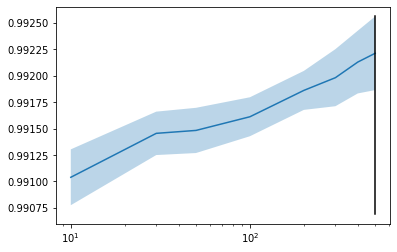

In [51]:
plot_score(grid_new)

In [52]:
y_pred_tf = grid_new.predict(X_val_vectorized)
y_pred_prob_tf = grid_new.predict_proba(X_val_vectorized)
print('f_1 score без рассчёта лучшего порогового значения : ',  f1_score(y_val, y_pred_tf))

f_1 score без рассчёта лучшего порогового значения :  0.9735228122662678


In [53]:
best_f1, the_best_thres = best_treshold(y_pred_prob_tf, y_val)
y_best_thres = (y_pred_prob_tf[:, 1] > the_best_thres).astype(bool)
print('f_1 score c рассчётом лучшего порогового значения : ', f1_score(y_val, y_best_thres))

f_1 score c рассчётом лучшего порогового значения :  0.9741353383458646


In [54]:
test_df = pd.read_csv('test.csv') # тоже самое для теста
test_new = prepare_text_data_new('test.csv', 'title', list_func, prepare_url(test_df))

In [55]:
test_new['title_new'] = test_new.title.apply(lambda raw: " ".join(raw))
list_title_test = test_new.title_new.tolist()
X_test = list_title_test
X_test_tfvect = tf_vectorized.transform(X_test)
y_test_proba = grid_new.predict_proba(X_test_tfvect)

y_test_best = (y_test_proba[:, 1] > the_best_thres).astype(bool)

In [56]:
test_df = pd.read_csv('test.csv')
test_df["target"] = y_test_best
test_df[["id", "target"]].to_csv("my_solve_final_1.csv", index = False)

!cat my_solve_final_1.csv | head
test_df.shape

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
cat: write error: Broken pipe


(165378, 4)